<a href="https://colab.research.google.com/github/eomorozova/NMA-DL-Project/blob/main/RNN_classifier_Steinmetz_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [65]:
#@title Importing Libraries

import os, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#@title CUDA Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#@title Plotting params

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# Load and plot Steinmetz neuropixel dataset

In [4]:
#@title Load Spike times from Steinmetz dataset
fname1 = ['steinmetz_st.npz']
fname1.append('steinmetz_wav.npz')
fname1.append('steinmetz_lfp.npz')
url2 = ["https://osf.io/4bjns/download"]
url2.append("https://osf.io/ugm9v/download")
url2.append("https://osf.io/kx3v9/download")


for j in range(len(url2)):
  if not os.path.isfile(fname1[j]):
    try:
      r = requests.get(url2[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname1[j], "wb") as fid:
          fid.write(r.content)


dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']
dat2 = dat_ST[11]
del dat_ST
print(dat2.keys())

dict_keys(['ss', 'ss_passive'])


In [5]:
#@title Load Binned Spike Times

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [6]:
#@title DF form
dt_waveforms = 1/30000 # dt of waveform
binsize = dat['bin_size'] # bin
mean_firing = dat['spks'].mean(axis = (1,2)) * 1/binsize # computing mean firing rate
t_t_peak = dat['trough_to_peak'] * dt_waveforms * 1e3 # computing trough to peak time in ms


labeling_df = pd.DataFrame({
    "Mean Firing Rate": mean_firing,
    "Trough to peak": t_t_peak,
    "Region": dat['brain_area'],
    "Area":dat['brain_area']
})
labeling_df.replace(
    {
        "Area": {"CA1":"Hippocampus","DG":"Hippocampus","SUB":"Hippocampus",
        "VISp": "Visual Ctx", "VISam":"Visual Ctx","MD":"Thalamus","LGd":"Thalamus", "LH":"Thalamus",
        "PL":"Other Ctx","MOs":"Other Ctx","ACA":"Other Ctx"
        }
    }, inplace = True
)

# Labeling according to conditions, other is the default condition
labeling_df['Cell Type'] = "Other"
labeling_df.loc[(labeling_df['Mean Firing Rate']<5)&(labeling_df['Trough to peak']>0.4),'Cell Type'] = "Excitatory"
labeling_df.loc[(labeling_df['Mean Firing Rate']>5)&(labeling_df['Trough to peak']<0.4), 'Cell Type'] = "Inhibitory"

labeling_df.head(20)

,Mean Firing Rate,Trough to peak,Region,Area,Cell Type
0,0.731765,0.800000,VISp,Visual Ctx,Excitatory
1,0.237647,0.666667,VISp,Visual Ctx,Excitatory
2,5.368235,0.766667,VISp,Visual Ctx,Other
3,0.190588,0.566667,DG,Hippocampus,Excitatory
4,1.356471,0.633333,VISp,Visual Ctx,Excitatory
5,0.000000,0.733333,VISp,Visual Ctx,Excitatory
6,0.141176,0.600000,SUB,Hippocampus,Excitatory
7,2.327059,0.733333,DG,Hippocampus,Excitatory
8,0.030588,0.633333,VISp,Visual Ctx,Excitatory
9,0.798824,0.400000,VISp,Visual Ctx,Other


In [7]:
labeling_df['Region'].unique()

array(['VISp', 'DG', 'SUB', 'LGd', 'PL', 'root', 'MOs', 'ACA', 'CA1',
       'VISam', 'MD', 'LH'], dtype=object)

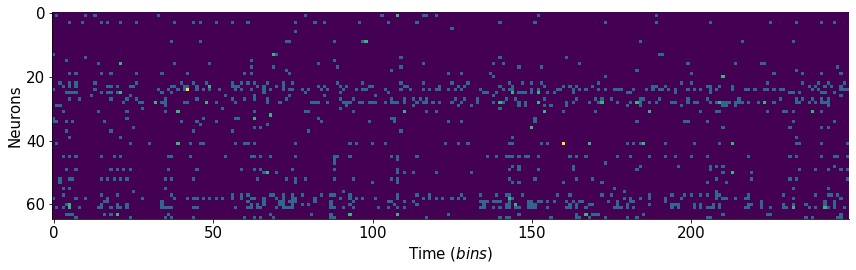

In [8]:
#dat['spks'][1,:,].shape
#Neurons,trials,time
plt.imshow(dat['spks'][dat['brain_area']=='DG',3,:])
plt.ylabel('Neurons');
plt.xlabel('Time ($bins$)');


In [9]:
#@title Raster visualizer
from ipywidgets import interact
import ipywidgets as widgets
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)
def raster_visualizer(area,trial):
  spikes= dat2['ss']
  plt.figure(figsize=(11,7))
  plt.eventplot(spikes[labeling_df['Area']==area][:,trial],color='k')
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Excitatory')][:,trial]);
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Other')][:,trial],color='k');
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Inhibitory')][:,trial],colors = 'r');
  #plt.yticks([]);
  plt.vlines(0.5,0,len(spikes[(labeling_df['Area']==area)])-10,'red','--',alpha=0.5)
  plt.ylabel('Neurons');
  plt.xlabel('Time ($s$)');
  plt.title(f'Trial was correct?:{is_correct[trial]}')
interact(raster_visualizer, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx'], trial=(0,339));

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…

In [10]:
#@title Mean firing rate for correct and incorrect trials
# response = dat['response'] # right - nogo - left (-1, 0, 1)

def mean_firing(area):
  Selection = (labeling_df['Area']==area) #& (labeling_df['Cell Type']=='Excitatory')
  spikes = dat['spks'][Selection].mean(axis = 0) #selecting spikes
  mean_fr_e = spikes[is_correct==True].mean(axis=(0))*1/binsize
  mean_fr_i = spikes[is_correct==False].mean(axis=(0))*1/binsize
  time = binsize * np.arange(dat['spks'].shape[-1])
  plt.plot(time, mean_fr_e,label='correct')
  plt.plot(time, mean_fr_i,label='incorrect')
  plt.axvline(x=0.5,ls = '--', alpha = 0.5, c = 'r', label='Stim')
  plt.axvline(x=np.mean(dat['response_time']),ls = '--', alpha = 0.5, c = 'k', label='Response')
  plt.ylabel('Mean Firing Rate ($Hz$)')
  plt.xlabel('Time ($ms$)')
  plt.legend()
interact(mean_firing, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx']);

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…

# RNN Classifier of correct and incorrect trials

In [11]:
#@title set up RNN
class RNNClass(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,num_classes):
    super(RNNClass,self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size,hidden_size,num_layers)
    self.fc = nn.Linear(hidden_size,num_classes)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers,x.size(1),self.hidden_size).to(device)
    out,h = self.rnn(x,h0)


    out = out[-1,:,:]
    out = torch.nn.functional.softmax(self.fc(out))
    return out, h


# Prepare the data for RNN

In [95]:
#@title Input: Binned spike times from Thalamus and associated labels, correct/incorrect trials
input = torch.from_numpy(dat['spks'][labeling_df['Area']=='Thalamus',:,:].T.astype(np.float32)).to(device)
#input = torch.from_numpy(dat['spks'][labeling_df['Area']=='Visual Ctx',:,:].T.astype(np.float32)).to(device)
labels = torch.from_numpy(is_correct.astype(np.int)).to(device)

In [96]:
#@title Take 70% of data for traininig
div_trials = 0.7
idx=np.random.choice(labels[labels==1].size(0),labels.size(0))

# determine the size of the training set
print(f'size of labels: {labels.size()[0]}')
print(f'size of 1s: {(labels==1).nonzero(as_tuple=True)[0].size(0)}')
print(f'size of 0s: {(labels==0).nonzero(as_tuple=True)[0].size(0)}')
#print('********************************')
#train_0s_size = int((labels==0).nonzero(as_tuple=True)[0].size(0)*div_trials)
#print(f'80% of 0s: {train_0s_size}')

size of labels: 340
size of 1s: 236
size of 0s: 104


The original dataset is imbalanced: more correct than incorrect trials.
Balance it by taking equal number of correct and incorrect trials

In [97]:
# getting balanced indexes for training

idx_1s = (labels==1).nonzero(as_tuple=True)[0]
size_0s_all = (labels==0).nonzero(as_tuple=True)[0].size(0)
size_0s = (labels==0).nonzero(as_tuple=True)[0].size(0)*0.7
size_0s = round(size_0s)

idx_1_train = idx_1s[:size_0s] # to match the size of labels 0
idx_0_train = (labels==0).nonzero(as_tuple=True)[0][:size_0s] 
idx_train = torch.cat((idx_1_train, idx_0_train), 0)
#print(idx_train,idx_train.size(0))

# getting balanced indexes for validation

idx_0_test = (labels==0).nonzero(as_tuple=True)[0][size_0s:]
idx_1_test = (labels==1).nonzero(as_tuple=True)[0][size_0s:size_0s_all]
idx_test = torch.cat((idx_1_test, idx_0_test), 0)
#print(idx_test,idx_test.size(0))

# getting balanced dataset

input_train = input[:,idx_train,:]
input_test = input[:,idx_test,:]

label_train = labels[idx_train]
label_test = labels[idx_test]

# shuffle the labels
idx_rand=[torch.randperm(label_train.size()[0])]
label_train_perm=label_train[idx_rand]
input_train_perm=input_train[:,torch.cat(idx_rand).numpy(),:]

idx_rand=[torch.randperm(label_test.size()[0])]
label_test_perm=label_test[idx_rand]
input_test_perm=input_test[:,torch.cat(idx_rand).numpy(),:]
#print(label_train_perm, label_train_perm.shape)

# RNN

In [101]:
#@title Set hyperparameters for RNN
input_size = input_train.size(-1)
hidden_size = 3
num_layers = 1
num_classes = 2
learning_rate = 0.0005
niter = 2000

In [ ]:
#@title Train and test the network
train_acc=[]
val_acc=[]
training_loss=[]
valid_loss=[]


model = RNNClass(input_size,hidden_size,num_layers,num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for k in range(niter):
  
  model.train()
  train_loss = 0.
  correct,total = 0, 0

  optimizer.zero_grad()
  outputs, h = model(input_train)
  #print(h)
  loss = criterion(outputs,label_train)
  loss.backward()
  optimizer.step()
  train_loss = loss.item()
  training_loss.append(train_loss)

  # get accuracy
  _, predicted = torch.max(outputs, 1)
  #print(predicted)
  total = label_train.size(0)
  correct = (predicted == label_train).sum().item()
  train_accuracy=100*correct/total
  train_acc.append(train_accuracy)

  if k % 100 == 0:
    #print(f'iteration {k}, cost {loss.item():.4f}')
    print(f'Epoch: {k + 1}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Training Accuracy: {100*correct/total: .2f}%')
    
  model.eval()
  correct, total = 0, 0

  with torch.no_grad():

    optimizer.zero_grad()
    outputs,h = model(input_test)

    loss = criterion(outputs, label_test)
    validation_loss = loss.item()
    valid_loss.append(validation_loss)

      # get accuracy
    _, predicted = torch.max(outputs, 1)
    total = label_test.size(0)
    correct = (predicted == label_test).sum().item()
    valid_accuracy=100*correct/total
    val_acc.append(valid_accuracy)

  if k % 100 == 0:
    print (f'Validation Loss: {validation_loss:.4f}, '
           f'Validation Accuracy: {100*correct/total: .2f}%')

Text(0, 0.5, 'Loss')

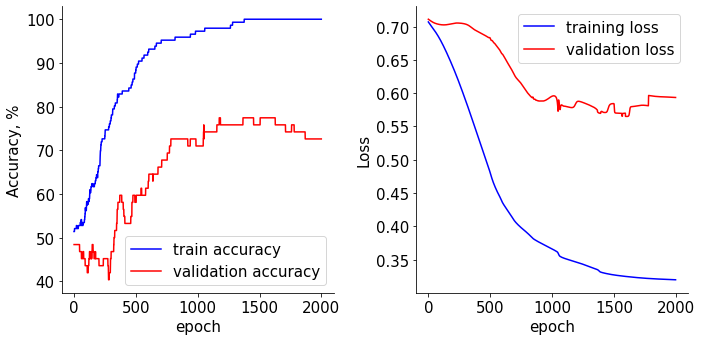

In [103]:
#@title Plot accuracy for training and test datasets and a loss
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, niter), train_acc, label='train accuracy', color='blue')
plt.plot(np.arange(0, niter), val_acc, label='validation accuracy', color='red')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('Accuracy, %')

plt.subplot(1,2,2)
plt.plot(np.arange(0, niter), training_loss, label='training loss', color='blue')
plt.plot(np.arange(0, niter), valid_loss, label='validation loss', color='red')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Loss')

# uncomment to save the figure
#from google.colab import files
#plt.savefig('accuracy_loss_thalamus.png')
#files.download("accuracy_loss_thalamus.png") 

In [104]:
#@title Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(label_test.cpu().numpy(), predicted.cpu().numpy())
# tn,fp,fn,tp

array([[28,  3],
       [14, 17]])

# Explore the latent state of RNN

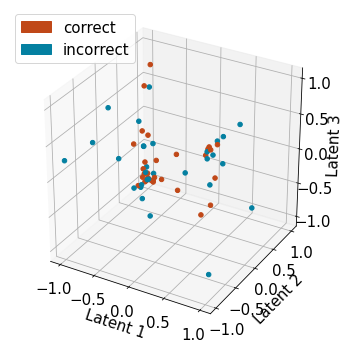

In [106]:
# plot latents
col = np.array(['#C04818','#0480A1'])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
h = h.cpu()
label_test_perm = label_test_perm.cpu()
#plt.scatter(h[0,:,0], h[0,:,1], c=col[label_test_perm], s=20, edgecolors='none')
ax.scatter(h[0,:,0], h[0,:,1], h[0,:,2],c=col[label_test_perm],alpha=1)
ax.set_xlabel('Latent 1')
ax.set_ylabel('Latent 2')
ax.set_zlabel('Latent 3')
pop_a = mpatches.Patch(color=col[0], label='correct')
pop_b = mpatches.Patch(color=col[1], label='incorrect')
plt.legend(handles=[pop_a,pop_b],loc='upper left')


#plt.scatter(h[0,:,0], h[0,:,1], s=20, edgecolors='none')